In [158]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [159]:
# Define path

path = r'C:\Users\dbnew\Achievement_6'

In [160]:
#Import data
df = pd.read_pickle(os.path.join(path, 'Prepared_Data', 'air_qual_cleaned.pkl'))

### 1. Subsetting, wrangling, and cleaning time-series data

In [161]:
df.columns

Index(['WHO Region', 'WHO Country Name', 'City or Locality',
       'Measurement Year', 'PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)',
       'PM25 temporal coverage (%)', 'PM10 temporal coverage (%)',
       'NO2 temporal coverage (%)', 'Reference',
       'Number and type of monitoring stations', 'Version of the database'],
      dtype='object')

In [162]:
data_sub=df[['Measurement Year', 'PM2.5 (μg/m3)' ]]

In [163]:
data_sub.rename(columns={'Measurement Year': 'Year'}, inplace=True) 

In [164]:
data_sub.head()

,Year,PM2.5 (μg/m3)
0,2021,12.63
1,2021,18.91
2,2021,14.86
3,2021,35.47
4,2021,23.39


In [165]:
data_agg=data_sub.groupby('Year').agg({'PM2.5 (μg/m3)': ['mean']})

In [166]:
data_agg.head()

,PM2.5 (μg/m3)
,mean
Year,
2000,NaN
2001,NaN
2002,NaN
2003,NaN
2004,NaN


In [167]:
#Remove missing values
data_agg.dropna(inplace=True)

In [168]:
data_agg.head()

,PM2.5 (μg/m3)
,mean
Year,
2010,17.571288
2011,21.363806
2012,21.582371
2013,16.160534
2014,22.196178


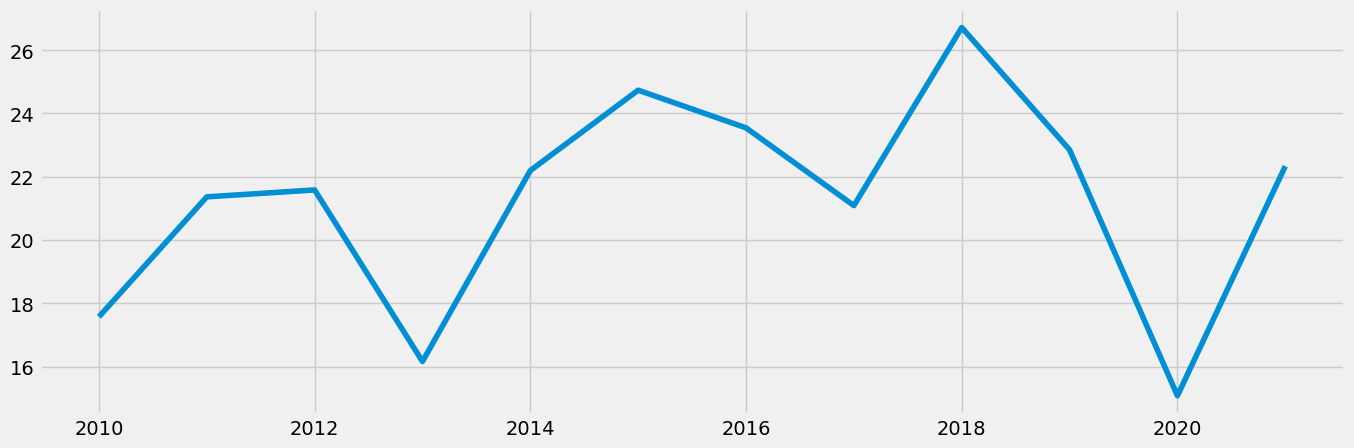

In [169]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_agg)

### 2. Time-series analysis: decomposition

In [171]:
data_agg2=data_agg.reset_index()

In [172]:
data_agg2.head()

,Year,PM2.5 (μg/m3)
,,mean
0,2010,17.571288
1,2011,21.363806
2,2012,21.582371
3,2013,16.160534
4,2014,22.196178


In [182]:
from datetime import datetime

data_agg2['datetime'] = pd.to_datetime(data_agg2['Year'], format='%Y') # Create a datetime column from "Date.""

In [179]:
data_agg2.head()

,Year,PM2.5 (μg/m3),datetime
,,mean,
0,2010,17.571288,2010-01-01
1,2011,21.363806,2011-01-01
2,2012,21.582371,2012-01-01
3,2013,16.160534,2013-01-01
4,2014,22.196178,2014-01-01


In [183]:
data_agg2 = data_agg2.set_index('datetime') # Set the datetime as the index of the dataframe.
data_agg2.drop(['Year'], axis=1, inplace=True) # Drop the "Date" column.
data_agg2.head()

,PM2.5 (μg/m3)
,mean
datetime,
2010-01-01,17.571288
2011-01-01,21.363806
2012-01-01,21.582371
2013-01-01,16.160534
2014-01-01,22.196178


In [184]:
decomposition = sm.tsa.seasonal_decompose(data_agg2, model='additive')

In [185]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

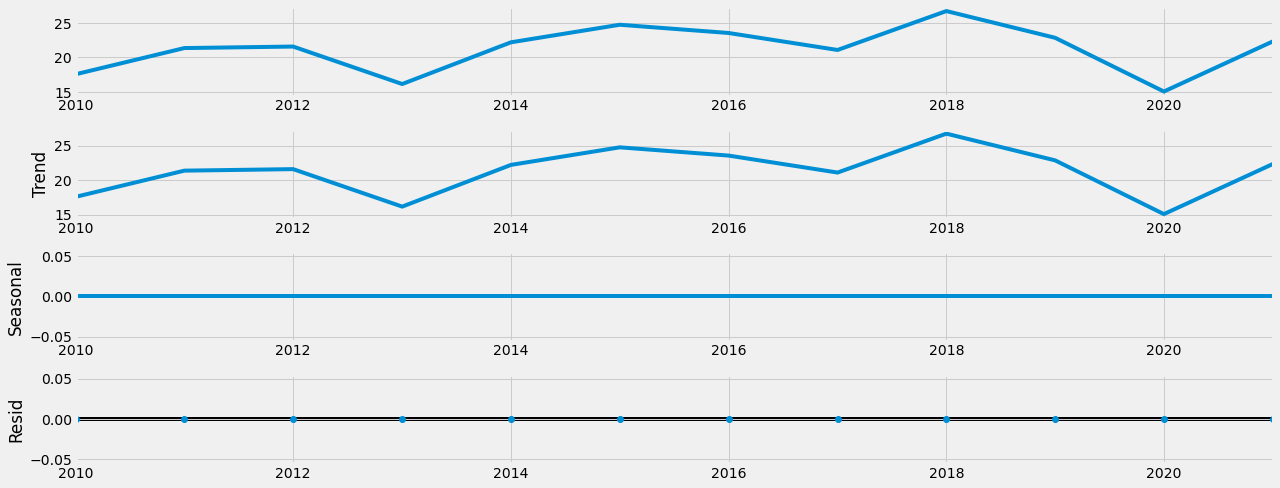

In [186]:
# Plot the separate components

decomposition.plot()
plt.show()

In [188]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why I need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_agg2['PM2.5 (μg/m3)'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.411241
p-value                        0.576875
Number of Lags Used            4.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


The test statistic is larger than the critical value so we can't reject the null hypothesis. This means there is a unit root in the data. The data is therefore non-stationary.

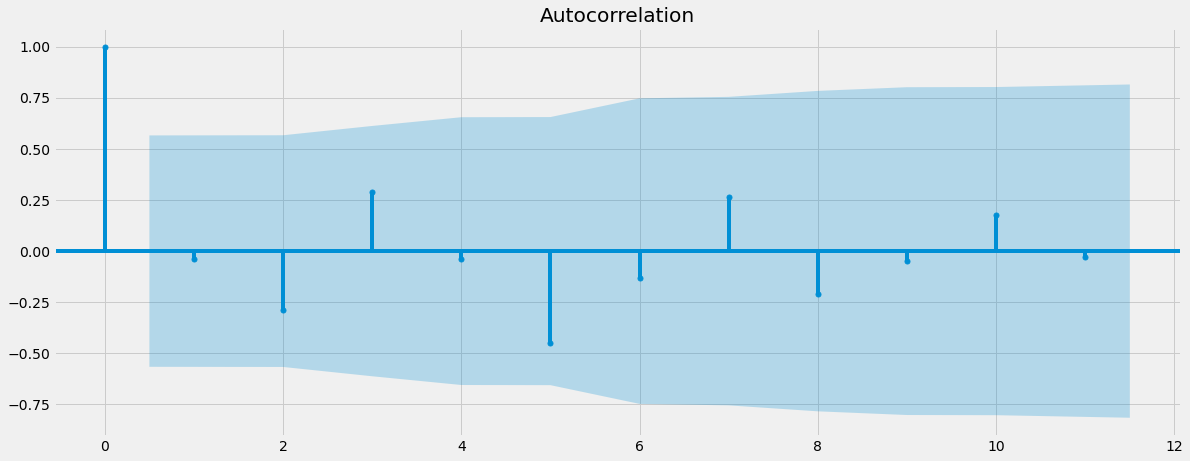

In [189]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, I'm importing the autocorrelation and partial correlation plots

plot_acf(data_agg2)
plt.show()

Most of the lags do not go outside the confidence interval so it doesn't tell us much about the significant correlations.

### 5. Stationarizing the WHO Air Pollution Data

In [190]:
data_diff = data_agg2 - data_agg2.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [191]:
data_diff.dropna(inplace = True) # Removing the missing values that came about as a result of the differencing. 
# Need to remove these or won't be able to run the Dickey-Fuller test.

In [192]:
data_diff.head()

,PM2.5 (μg/m3)
,mean
datetime,
2011-01-01,3.792519
2012-01-01,0.218565
2013-01-01,-5.421837
2014-01-01,6.035644
2015-01-01,2.540402


In [193]:
data_diff.columns

MultiIndex([('PM2.5 (μg/m3)', 'mean')],
           )

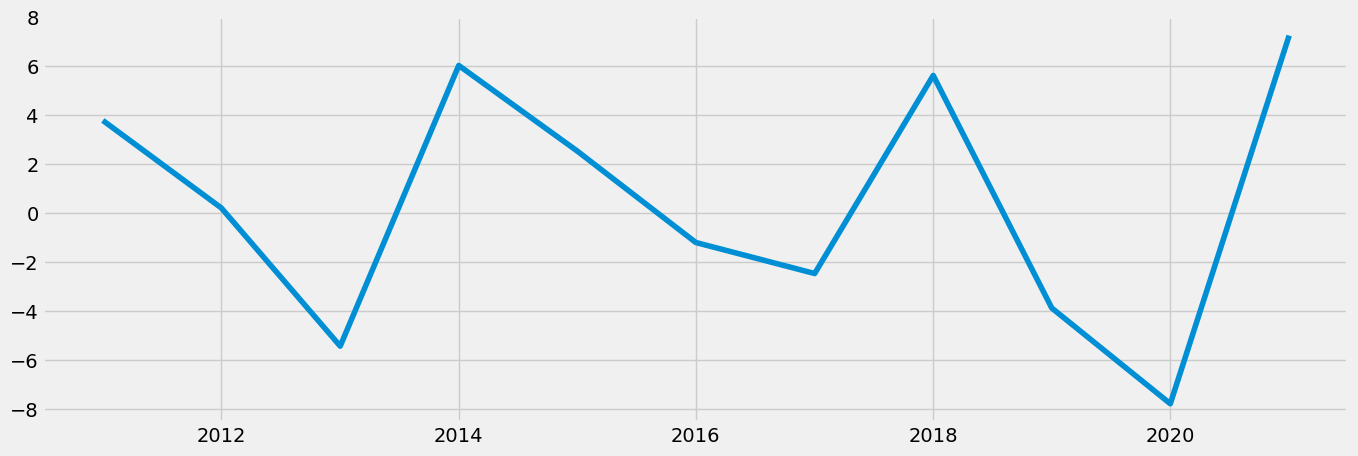

In [194]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [195]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -5.267827
p-value                        0.000006
Number of Lags Used            1.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


The test statistic is lower than the critical value so we can reject the null hypothesis. The data should now be stationary.

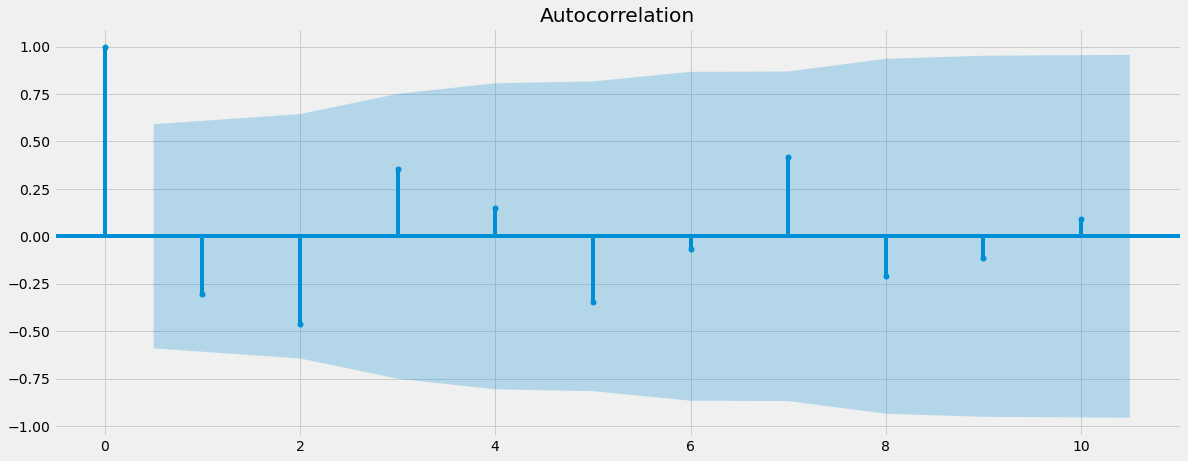

In [196]:
plot_acf(data_diff)
plt.show()

The autocorrelation looks the same as before.  As before, most points are not significantly correlated, so we can assume the data is now stationary.